Running GA on training_1.txt...
Generation 1
Gen 1: Min Cost = 70764100.0, Avg Cost = 75364236.44
Generation 2
Gen 2: Min Cost = 69788500.0, Avg Cost = 73885640.85
Generation 3
Gen 3: Min Cost = 69111325.0, Avg Cost = 72481169.75625
Generation 4
Gen 4: Min Cost = 68280881.0, Avg Cost = 71220603.08625
Generation 5
Gen 5: Min Cost = 67029615.0, Avg Cost = 70062809.8875
Generation 6
Gen 6: Min Cost = 66262048.0, Avg Cost = 68908372.63625
Generation 7
Gen 7: Min Cost = 66114463.0, Avg Cost = 67969136.30125
Generation 8
Gen 8: Min Cost = 65264284.0, Avg Cost = 67121784.56125
Generation 9
Gen 9: Min Cost = 64695111.0, Avg Cost = 66372663.0975
Generation 10
Gen 10: Min Cost = 63856555.0, Avg Cost = 65711841.62125
Generation 11
Gen 11: Min Cost = 63340855.0, Avg Cost = 65065047.26875
Generation 12
Gen 12: Min Cost = 62965499.0, Avg Cost = 64424963.1975
Generation 13
Gen 13: Min Cost = 61466419.0, Avg Cost = 63769638.5825
Generation 14
Gen 14: Min Cost = 61331952.0, Avg Cost = 63115386.17
Gener

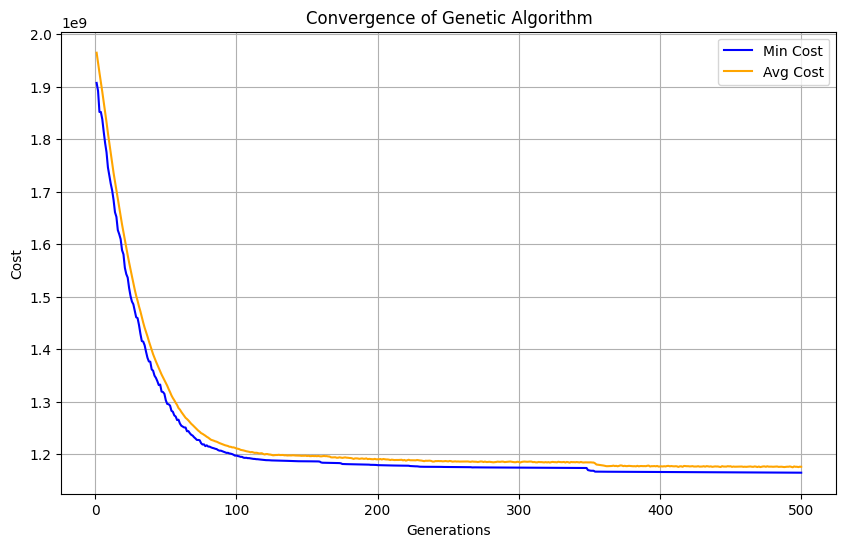

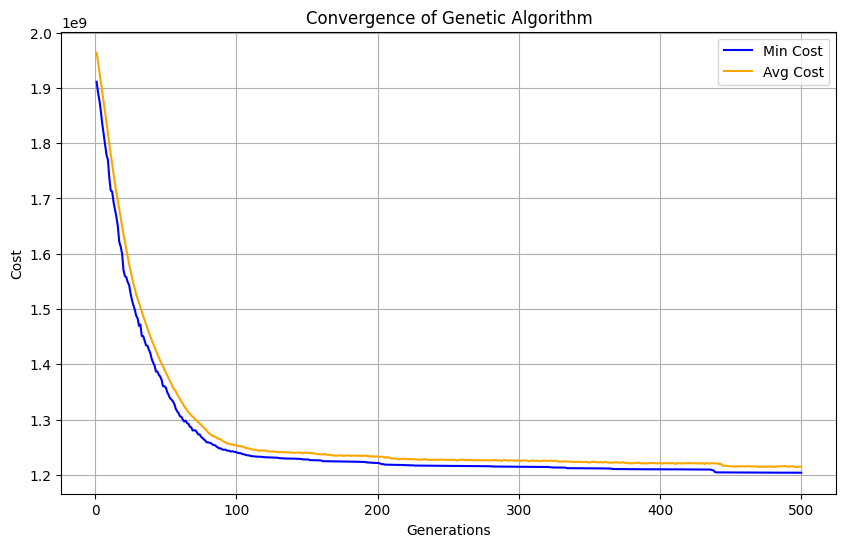

In [3]:
"""
Name: Moses Hashini Sharon
TP Number: TP053387

Case Study: Technician Scheduling and Delivery Optimization using Genetic Algorithm

Overview:
----------
This case study involves scheduling the delivery and installation of machines across multiple locations using a fleet of trucks and a team of technicians. The goal is to minimize the overall cost, which includes the truck travel cost, technician travel cost, and penalties for idle machines (i.e., machines that are delivered but not installed). The problem is complex due to various constraints, such as limited truck capacity, technician skills, maximum working days, and delivery time windows.

Genetic Algorithm Approach:
----------------------------
We use a Genetic Algorithm (GA) to find an optimal or near-optimal solution for the scheduling problem. The GA evolves a population of possible schedules (individuals) by applying selection, crossover, mutation, and evaluation over several generations. The individuals are evaluated based on a fitness function that considers both the total cost and penalties for constraint violations. 

Key GA Parameters:
- Population Size: Number of potential solutions (schedules) at each generation.
- Crossover Probability (cxpb): The likelihood of combining two schedules to produce a new one.
- Mutation Probability (mutpb): The likelihood of randomly altering a schedule to explore new possibilities.
- Number of Generations: The number of iterations the GA will run to refine the solutions.

Soft Constraints:
------------------
These constraints are flexible and can be violated, but doing so incurs a penalty, which the GA tries to minimize:
1. **Idle Machine Penalty**: A penalty is applied for each day a machine is delivered but not installed.
2. **Technician Travel Cost**: This cost is based on the distance traveled by the technician each day.
3. **Truck Travel Cost**: This cost is based on the distance traveled by the trucks for delivery.

Hard Constraints:
-------------------
These constraints must be strictly adhered to, and violating them results in significant penalties or invalid solutions:
1. **Truck Capacity**: Each truck has a limited capacity, and the total size of machines in each trip must not exceed this limit.
2. **Delivery Window**: Each request has a specific time window for delivery (start and end day). Machines must be delivered within this window.
3. **Technician Skill Matching**: Technicians can only install machines that they are trained to handle. A violation occurs if an unskilled technician is assigned to install a machine.
4. **Max Working Days**: Technicians cannot work more than 5 consecutive days without a mandatory rest period.
5. **Truck Max Distance**: Trucks can only travel a maximum distance each day.

Objectives:
------------
The main objective is to minimize the total cost by optimizing:
- Truck usage (minimizing travel distance and number of trucks used).
- Technician scheduling (minimizing travel distance and idle time).
- Reducing idle machine penalties.

Inputs:
--------
The input files (`training_1.txt`, `training_2.txt`, etc.) define the problem instances, which include:
- The number of days available for delivery and installation.
- A list of locations (including the depot).
- Machines, requests, technicians, and their properties (e.g., skills, max distance, etc.).
- Truck properties (e.g., capacity, max distance).

Outputs:
---------
The GA returns the best solution found, including:
- The total cost (including penalties).
- The number of trucks and technicians used.
- The detailed daily schedule for trucks and technicians.

This solution is printed using the `print_formatted_solution()` function, which provides a detailed breakdown of the schedule and costs.
"""

import random
import numpy as np
from deap import base, creator, tools, algorithms
import math
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import matplotlib.pyplot as plt
from deap import tools

# ----------------------------
# Data Structures Definitions
# ---------------------------

class Machine:
    def __init__(self, machine_id, size, idle_penalty):
        self.machine_id = machine_id
        self.size = size
        self.idle_penalty = idle_penalty


class Location:
    def __init__(self, location_id, x, y):
        self.location_id = location_id
        self.x = x
        self.y = y

class Request:
    def __init__(self, request_id, location_id, delivery_start, delivery_end, machine_type, quantity):
        self.request_id = request_id
        self.location_id = location_id
        self.delivery_start = delivery_start
        self.delivery_end = delivery_end
        self.machine_type = machine_type
        self.quantity = quantity

class Technician:
    def __init__(self, tech_id, home_location_id, max_distance, max_requests, skills):
        self.tech_id = tech_id
        self.home_location_id = home_location_id
        self.max_distance = max_distance
        self.max_requests = max_requests
        self.skills = skills  # Dict of {machine_type_id: 1 or 0}, indicating technician's skills

class ProblemInstance:
    def __init__(self):
        self.days = 0
        self.truck_capacity = 0
        self.truck_max_distance = 0
        self.truck_distance_cost = 0
        self.truck_day_cost = 0
        self.truck_cost = 0
        self.technician_distance_cost = 0
        self.technician_day_cost = 0
        self.technician_cost = 0
        self.machines = {}  # Dict of Machine objects
        self.locations = {}  # Dict of Location objects
        self.requests = []  # List of Request objects
        self.technicians = []  # List of Technician objects
        self.max_consecutive_working_days = 5 


# ----------------------------
# Utility Functions
# ----------------------------

def euclidean_distance(loc1, loc2):
    """Calculate the ceiling of the Euclidean distance between two locations."""
    return math.ceil(math.sqrt((loc1.x - loc2.x) ** 2 + (loc1.y - loc2.y) ** 2))


def parse_input(file_path):
    """
    Parses the input data file and returns a ProblemInstance object.
    """
    problem = ProblemInstance()
    with open(file_path, 'r') as file:
        lines = file.readlines()

    idx = 0
    while idx < len(lines):
        line = lines[idx].strip()
        if not line or line.startswith('#'):
            idx += 1
            continue
        
        if line.startswith("DAYS"):
            problem.days = int(line.split('=')[1].strip())
            idx += 1
        elif line.startswith("TRUCK_CAPACITY"):
            problem.truck_capacity = int(line.split('=')[1].strip())
            idx += 1
        elif line.startswith("TRUCK_MAX_DISTANCE"):
            problem.truck_max_distance = int(line.split('=')[1].strip())
            idx += 1
        elif line.startswith("TRUCK_DISTANCE_COST"):
            problem.truck_distance_cost = int(line.split('=')[1].strip())
            idx += 1
        elif line.startswith("TRUCK_DAY_COST"):
            problem.truck_day_cost = int(line.split('=')[1].strip())
            idx += 1
        elif line.startswith("TRUCK_COST"):
            problem.truck_cost = int(line.split('=')[1].strip())
            idx += 1
        elif line.startswith("TECHNICIAN_DISTANCE_COST"):
            problem.technician_distance_cost = int(line.split('=')[1].strip())
            idx += 1
        elif line.startswith("TECHNICIAN_DAY_COST"):
            problem.technician_day_cost = int(line.split('=')[1].strip())
            idx += 1
        elif line.startswith("TECHNICIAN_COST"):
            problem.technician_cost = int(line.split('=')[1].strip())
            idx += 1
        elif line.startswith("MACHINES"):
            num_machines = int(line.split('=')[1].strip())
            idx += 1
            for _ in range(num_machines):
                parts = lines[idx].strip().split()
                machine_id = int(parts[0])
                size = int(parts[1])
                idle_penalty = int(parts[2])
                problem.machines[machine_id] = Machine(machine_id, size, idle_penalty)
                idx += 1
        elif line.startswith("LOCATIONS"):
            num_locations = int(line.split('=')[1].strip())
            idx += 1
            for _ in range(num_locations):
                parts = lines[idx].strip().split()
                location_id = int(parts[0])
                x = int(parts[1])
                y = int(parts[2])
                
                # Ensure that no customer has location ID 1
                if location_id == 1 and len(problem.locations) > 0:
                    raise ValueError("Location ID 1 is reserved for the depot. Customers cannot have Location ID 1.")
                
                problem.locations[location_id] = Location(location_id, x, y)
                idx += 1

        elif line.startswith("REQUESTS"):
            num_requests = int(line.split('=')[1].strip())
            idx += 1
            for _ in range(num_requests):
                parts = lines[idx].strip().split()
                request_id = int(parts[0])
                location_id = int(parts[1])
                
                # Ensure that no customer request refers to location ID 1 (depot)
                if location_id == 1:
                    raise ValueError(f"Request {request_id} has an invalid location: Location ID 1 is reserved for the depot.")
                
                delivery_start = int(parts[2])
                delivery_end = int(parts[3])
                machine_type = int(parts[4])
                quantity = int(parts[5])
                problem.requests.append(
                    Request(request_id, location_id, delivery_start, delivery_end, machine_type, quantity))
                idx += 1

        elif line.startswith("TECHNICIANS"):
            num_technicians = int(line.split('=')[1].strip())
            idx += 1
            for _ in range(num_technicians):
                parts = lines[idx].strip().split()
                tech_id = int(parts[0])
                home_location_id = int(parts[1])
                max_distance = int(parts[2])
                max_requests = int(parts[3])
                
                # Skills processing
                skills = {}
                skill_parts = parts[4:]  # The skills are provided as a list of 0's and 1's
                
                for machine_id, skill_value in enumerate(skill_parts, start=1):
                    skills[machine_id] = int(skill_value)  # Assign skill for each machine type (1-indexed)
                problem.technicians.append(Technician(tech_id, home_location_id, max_distance, max_requests, skills))
                idx += 1

    return problem


# ----------------------------
# Genetic Algorithm Components
# ----------------------------
def initialize_individual(problem):
    """
    Initializes an individual solution, which consists of a schedule for trucks and technicians.
    The schedule covers multiple days, and ensures that delivery and installation constraints are respected.
    """
    individual = []
    
    # Track delivered and installed requests
    request_delivered = set()
    request_installed = set()
    request_delivery_days = {}
    
    technician_consecutive_working_days = {tech.tech_id: 0 for tech in problem.technicians}
    technician_days_off = {tech.tech_id: 0 for tech in problem.technicians}
    
    idle_machines = set()
    
    for day in range(1, problem.days + 1):
        day_schedule = {  # Chromosome
            'day': day,
            'trucks': [],      # Schedule for truck deliveries
            'technicians': [], # Schedule for technician installations
            'idle_machines': [] # Machines delivered but not installed
        }
        
        # Step 1: Assign delivery tasks to trucks for the day
        available_requests = [
            req for req in problem.requests 
            if req.delivery_start <= day <= req.delivery_end and req.request_id not in request_delivered
        ]
        truck_id = 1
        random.shuffle(available_requests)

        while available_requests:
            truck_schedule = {
                'truck_id': truck_id,
                'trips': []  # Each truck will have a list of trips with a set of requests delivered
            }
            truck_capacity = problem.truck_capacity
            truck_distance_remaining = problem.truck_max_distance
            previous_location = problem.locations[1]  # Start from depot
            
            while available_requests and truck_distance_remaining > 0:
                trip = []
                trip_capacity = 0
                trip_distance = 0
                trip_requests = []  # Keep track of request ids for this trip

                # Loop through available requests, assigning them to the current trip if possible
                for req in available_requests[:]:  
                    machine = problem.machines[req.machine_type]
                    size = req.quantity * machine.size
                    distance_to_request = euclidean_distance(previous_location, problem.locations[req.location_id])
                    distance_back_to_depot = euclidean_distance(problem.locations[req.location_id], problem.locations[1])
                    
                    round_trip_distance = distance_to_request + distance_back_to_depot
                    
                    # Check if this request can fit into the trip
                    if (trip_capacity + size <= truck_capacity and 
                        trip_distance + round_trip_distance <= truck_distance_remaining):
                        
                        trip.append(req.request_id)  # Add request to trip
                        previous_location = problem.locations[req.location_id]  # Update truck's location
                        available_requests.remove(req)  # Remove the request from the list
                        request_delivered.add(req.request_id)
                        request_delivery_days[req.request_id] = day
                        trip_capacity += size
                        trip_distance += distance_to_request  # Add distance to customer
                        trip_requests.append(req.request_id)
                    else:
                        break  # No more requests can fit into this trip
                
                if trip:
                    truck_schedule['trips'].append(trip_requests)  # Add the trip to the truck's schedule
                    truck_distance_remaining -= (trip_distance + distance_back_to_depot)  # Deduct the total round-trip distance
                    truck_capacity = problem.truck_capacity  # Reset capacity for the next trip
                    previous_location = problem.locations[1]  # Return to depot
                else:
                    break  # No more trips possible for this truck
            
            if truck_schedule['trips']:
                day_schedule['trucks'].append(truck_schedule)  # Add the truck's schedule to the day's schedule
                truck_id += 1
        
        # Step 2: Assign technician installation tasks
        random.shuffle(problem.technicians)
        for tech in problem.technicians:
            if technician_consecutive_working_days[tech.tech_id] >= 5:  # Technician day-off rule
                if technician_days_off[tech.tech_id] < 2:
                    technician_days_off[tech.tech_id] += 1
                    continue  # Technician takes a day off
                else:
                    technician_consecutive_working_days[tech.tech_id] = 0
                    technician_days_off[tech.tech_id] = 0
            
            # Find requests that have been delivered but not yet installed
            possible_requests = [
                req for req in problem.requests 
                if req.request_id not in request_installed
                and req.request_id in request_delivered
                and request_delivery_days[req.request_id] < day  # Can only be installed after delivery
                and tech.skills.get(req.machine_type, 0)  # Technician must have the skill
                and euclidean_distance(problem.locations[tech.home_location_id], problem.locations[req.location_id]) <= tech.max_distance
            ]
            
            assigned_requests = possible_requests[:tech.max_requests]  # Assign technician's maximum request limit
            
            if assigned_requests:
                technician_schedule = {
                    'technician_id': tech.tech_id,
                    'requests': [req.request_id for req in assigned_requests]
                }
                day_schedule['technicians'].append(technician_schedule)
                
                # Mark the requests as installed
                for req in assigned_requests:
                    request_installed.add(req.request_id)
                    idle_machines.discard(req.request_id)
                technician_consecutive_working_days[tech.tech_id] += 1
                technician_days_off[tech.tech_id] = 0
            else:
                technician_days_off[tech.tech_id] += 1
        
        # Step 3: Track idle machines
        for req in problem.requests:
            if req.request_id in request_delivered and req.request_id not in request_installed:
                idle_machines.add(req.request_id)
        
        day_schedule['idle_machines'] = list(idle_machines)
        individual.append(day_schedule)
    
    return individual


def evaluate(individual, problem):
    """
    Calculate the total cost of the schedule represented by the individual.
    Applies penalties for constraint violations.
    """
    # Penalty counters
    technician_request_violation = 0
    delivery_installation_violation = 0
    duplicate_delivery_request_violation = 0
    duplicate_installation_violation = 0
    delivery_day_window_violation = 0
    truck_distance_violation = 0
    technician_travel_dist_violation = 0

    # Cost components
    technician_travel_cost = 0
    truck_hire_cost = 0
    truck_distance_cost = 0
    machine_idle_cost = 0

    # Tracking variables
    request_map = {req.request_id: req for req in problem.requests}
    technician_map = {tech.tech_id: tech for tech in problem.technicians}
    request_delivery_days = {}
    request_installation_days = {}
    technician_consecutive_working_days = {tech.tech_id: 0 for tech in problem.technicians}
    technician_last_work_day = {tech.tech_id: 0 for tech in problem.technicians}

    max_trucks_used = 0
    total_truck_days = 0
    total_technician_days = 0

    for day_index, day_schedule in enumerate(individual):
        day = day_index + 1
        trucks = day_schedule['trucks']
        technicians = day_schedule['technicians']

        # Process trucks
        total_truck_days += len(trucks)
        max_trucks_used = max(max_trucks_used, len(trucks))

        for truck in trucks:
            truck_distance = 0
            for trip in truck['trips']:
                trip_distance = 0
                trip_capacity = 0
                previous_location = problem.locations[1]  # Depot

                for rid in trip:
                    req = request_map[rid]
                    loc = problem.locations[req.location_id]
                    distance = euclidean_distance(previous_location, loc)
                    size = req.quantity * problem.machines[req.machine_type].size
                    trip_distance += distance
                    trip_capacity += size
                    previous_location = loc

                    # Check for duplicate delivery requests
                    if rid in request_delivery_days:
                        duplicate_delivery_request_violation += 10000
                    else:
                        request_delivery_days[rid] = day

                    # Delivery window check
                    if not (req.delivery_start <= day <= req.delivery_end):
                        delivery_day_window_violation += 10000  # Penalty for delivery outside window

                # Return to depot
                trip_distance += euclidean_distance(previous_location, problem.locations[1])
                truck_distance += trip_distance

                # Capacity check
                if trip_capacity > problem.truck_capacity:
                    truck_distance_violation += 10000  # Penalty for exceeding truck capacity

            # Distance check
            if truck_distance > problem.truck_max_distance:
                truck_distance_violation += 10000  # Penalty for exceeding truck max distance

            truck_distance_cost += truck_distance * problem.truck_distance_cost

        # Process technicians
        total_technician_days += len(technicians)

        for tech_schedule in technicians:
            tech_id = tech_schedule['technician_id']
            tech = technician_map[tech_id]
            requests = tech_schedule['requests']

            # Check technician max requests
            if len(requests) > tech.max_requests:
                technician_request_violation += 10000  # Penalty for exceeding technician's max requests

            # Day off rule
            if technician_consecutive_working_days[tech_id] >= 5:
                technician_request_violation += 10000  # Penalty for violating day off rule

            # Update working days tracking
            if technician_last_work_day[tech_id] == day - 1:
                technician_consecutive_working_days[tech_id] += 10000
            else:
                technician_consecutive_working_days[tech_id] = 10000
            technician_last_work_day[tech_id] = day

            # Skills check and distance calculation
            tech_distance = 0
            previous_location = problem.locations[tech.home_location_id]

            for rid in requests:
                req = request_map[rid]
                loc = problem.locations[req.location_id]

                # Skills check
                if not tech.skills.get(req.machine_type, 0):
                    technician_request_violation += 10000

                if rid not in request_delivery_days or request_delivery_days[rid] >= day:
                    delivery_installation_violation += 10000 # Penalty for installing before delivery

                # Check for duplicate installation requests
                if rid in request_installation_days:
                    duplicate_installation_violation += 10000
                else:
                    request_installation_days[rid] = day

                # Distance calculation
                distance = euclidean_distance(previous_location, loc)
                tech_distance += distance
                previous_location = loc

            # Return to home
            tech_distance += euclidean_distance(previous_location, problem.locations[tech.home_location_id])

            # Distance check
            if tech_distance > tech.max_distance:
                technician_travel_dist_violation += 10000 # Penalty for exceeding technician's max travel distance

            technician_travel_cost += tech_distance * problem.technician_distance_cost

        # Idle machine penalties
        for req in problem.requests:
            if req.request_id in request_delivery_days and req.request_id not in request_installation_days:
                delivery_day = request_delivery_days[req.request_id]
                idle_days = day - delivery_day
                if idle_days > 0: 
                    machine_type = problem.machines[req.machine_type]
                    machine_idle_cost += idle_days * machine_type.idle_penalty * req.quantity

    truck_hire_cost = max_trucks_used * problem.truck_cost
    #total cost
    total_cost = technician_travel_cost + truck_hire_cost + truck_distance_cost + machine_idle_cost

    # Calculate Validity 
    validity = (
        technician_request_violation
        + delivery_installation_violation 
        + duplicate_delivery_request_violation 
        + duplicate_installation_violation 
        + delivery_day_window_violation
        + truck_distance_violation  
        + technician_travel_dist_violation  
    )   

    violations = technician_request_violation + delivery_installation_violation+ duplicate_installation_violation+ duplicate_delivery_request_violation+truck_distance_violation+delivery_day_window_violation+technician_travel_dist_violation
    evaluation_score = validity + total_cost #fitness score

    return (evaluation_score,), {
        'total_truck_days': total_truck_days,
        'total_truck_distance': truck_distance_cost,
        'total_technician_days': total_technician_days,
        'technician_travel_cost': technician_travel_cost,
        'idle_machine_cost': machine_idle_cost,
        'violations_count': violations,
    }


def mutate_individual(individual, problem, indpb=0.5):
    """
    Mutates the individual's truck and technician schedules with the specified probability.
    """
    for day_index, day_schedule in enumerate(individual):
        if random.random() < indpb:
            # Mutate trucks
            if day_schedule['trucks']:
                truck = random.choice(day_schedule['trucks'])
                if truck['trips']:
                    trip = random.choice(truck['trips'])
                    if trip:
                        if random.random() < 0.5 and len(trip) > 1:
                            # Remove a request from the trip
                            removed_request = random.choice(trip)
                            trip.remove(removed_request)
                        else:
                            # Try to add a request to the trip, ensuring no duplicate delivery
                            possible_requests = [
                                req for req in problem.requests 
                                if req.request_id not in trip
                                and all(req.request_id not in truck_trip for truck_trip in truck['trips']) 
                                and all(req.request_id not in tech_schedule['requests'] for tech_schedule in day_schedule['technicians'])
                                and req.delivery_start <= day_index + 1 <= req.delivery_end
                            ]
                            if possible_requests:
                                new_request = random.choice(possible_requests)
                                machine = problem.machines[new_request.machine_type]
                                size = new_request.quantity * machine.size
                                distance_to_request = euclidean_distance(problem.locations[1], problem.locations[new_request.location_id])
                                distance_back_to_depot = euclidean_distance(problem.locations[new_request.location_id], problem.locations[1])

                                # Calculate truck's current load and distance
                                truck_current_capacity = sum(
                                    problem.machines[problem.requests[req_id].machine_type].size * problem.requests[req_id].quantity 
                                    for trip in truck['trips'] for req_id in trip
                                    if 0 <= req_id < len(problem.requests)  # Ensure valid request ID
                                )

                                # Calculate the truck's current distance traveled
                                truck_current_distance = sum(
                                    euclidean_distance(problem.locations[problem.requests[trip[i]].location_id], 
                                                       problem.locations[problem.requests[trip[i + 1]].location_id])
                                    for trip in truck['trips'] for i in range(len(trip) - 1)
                                    if 0 <= trip[i] < len(problem.requests) and 0 <= trip[i + 1] < len(problem.requests)  # Ensure valid request IDs
                                )

                                # Check if the new request can be added
                                if size <= problem.truck_capacity - truck_current_capacity and \
                                   distance_to_request + distance_back_to_depot <= problem.truck_max_distance - truck_current_distance:
                                    trip.append(new_request.request_id)

            # Mutate technicians
            if day_schedule['technicians']:
                tech_schedule = random.choice(day_schedule['technicians'])
                if tech_schedule['requests']:
                    if random.random() < 0.5 and len(tech_schedule['requests']) > 1:
                        # Remove a request from the technician's schedule
                        tech_schedule['requests'].remove(random.choice(tech_schedule['requests']))
                    else:
                        # Try to add a new request to the technician's schedule
                        tech = next((t for t in problem.technicians if t.tech_id == tech_schedule['technician_id']), None)

                        # Find possible requests for the technician to handle, respecting skills and max requests
                        possible_requests = [
                            req for req in problem.requests 
                            if req.request_id not in tech_schedule['requests']
                            and req.delivery_start < day_index + 1 <= req.delivery_end
                            and tech.skills.get(req.machine_type, 0)  # Ensure technician can handle the machine type
                            and len(tech_schedule['requests']) < tech.max_requests  # Respect max requests for technician
                        ]

                        # Prioritize idle machines to minimize penalties
                        idle_requests = [
                            req for req in possible_requests 
                            if req.request_id in day_schedule['idle_machines']
                        ]

                        if idle_requests:
                            tech_schedule['requests'].append(random.choice(idle_requests).request_id)
                        elif possible_requests:
                            tech_schedule['requests'].append(random.choice(possible_requests).request_id)

    return individual,


def crossover_individuals(ind1, ind2):
    """
    Perform crossover between two individuals.
    Uses uniform crossover for day schedules.
    """
    for day in range(len(ind1)):
        if random.random() < 0.5:
            # Swap day schedules between two individuals
            day1_schedule = ind1[day]
            day2_schedule = ind2[day]

            # Get all requests assigned in both days before swapping
            requests_in_day1 = {req_id for truck in day1_schedule['trucks'] for trip in truck['trips'] for req_id in trip}
            requests_in_day2 = {req_id for truck in day2_schedule['trucks'] for trip in truck['trips'] for req_id in trip}
            tech_requests_day1 = {req_id for tech in day1_schedule['technicians'] for req_id in tech['requests']}
            tech_requests_day2 = {req_id for tech in day2_schedule['technicians'] for req_id in tech['requests']}
            
            # Ensure no overlapping requests between trucks and technicians after crossover
            if not (requests_in_day1 & tech_requests_day2) and not (requests_in_day2 & tech_requests_day1):
                ind1[day], ind2[day] = ind2[day], ind1[day]
    
    return ind1, ind2


creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

def register_toolbox(problem):
    toolbox.register("individual", tools.initIterate, creator.Individual, lambda: initialize_individual(problem))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", crossover_individuals)
    toolbox.register("mutate", mutate_individual, problem=problem, indpb=0.5)
    toolbox.register("select", tools.selTournament, tournsize=5)
    toolbox.register("evaluate", evaluate, problem=problem)  



def print_formatted_solution(best_individual, technician_distance_total, truck_distance_total, idle_machine_cost_total, violations_count, name):
    # Same logic as before, using the extracted metrics from the evaluation function
    number_of_truck_days = 0
    number_of_trucks_used = 0
    number_of_technician_days = 0
    technicians_used = set()

    print(f"Name = {name}")
    print("**SOLUTION SUMMARY:**")
    
    for day_schedule in best_individual:
        trucks = day_schedule['trucks']
        technicians = day_schedule['technicians']

        # Truck calculations
        if trucks:
            number_of_truck_days += 1
            number_of_trucks_used = max(number_of_trucks_used, len(trucks))

        # Technician calculations
        if technicians:
            number_of_technician_days += 1
            for tech in technicians:
                technicians_used.add(tech['technician_id'])

    print(f"TRUCK_DISTANCE = {truck_distance_total}")
    print(f"NUMBER_OF_TRUCK_DAYS = {number_of_truck_days}")
    print(f"NUMBER_OF_TRUCKS_USED = {number_of_trucks_used}")
    print(f"TECHNICIAN_DISTANCE = {technician_distance_total}")
    print(f"NUMBER_OF_TECHNICIAN_DAYS = {number_of_technician_days}")
    print(f"NUMBER_OF_TECHNICIANS_USED = {len(technicians_used)}")
    print(f"IDLE_MACHINE_COSTS = {idle_machine_cost_total}")
    print(f"TOTAL_COST = {best_individual.fitness.values[0]}")
    print(f"VIOLATIONS_COUNT = {violations_count}")

    print("\n**SCHEDULE DETAILS**")
    for day in range(len(best_individual)):
        day_schedule = best_individual[day]
        print(f"DAY = {day + 1}")
        
        # Truck Details
        print(f"NUMBER_OF_TRUCKS = {len(day_schedule['trucks'])}")
        for truck in day_schedule['trucks']:
            trips_str = ' '.join(str(req_id) for trip in truck['trips'] for req_id in trip)
            print(f"{truck['truck_id']} {trips_str}")

        # Technician Details
        print(f"NUMBER_OF_TECHNICIANS = {len(day_schedule['technicians'])}")
        for tech in day_schedule['technicians']:
            requests_str = ' '.join(map(str, tech['requests']))
            print(f"{tech['technician_id']} {requests_str}")

        print()  


def run_ga(population, problem, cxpb, mutpb, ngen, stats=None, hof=None):
    """Run the Genetic Algorithm (GA) with the given population and parameters."""
    generations = []
    min_costs = []
    avg_costs = []

    if stats is None:
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("min", np.min)
        stats.register("avg", np.mean)

    if hof is None:
        hof = tools.HallOfFame(5)  

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit[0]

    for gen in range(1, ngen + 1):
        print(f"Generation {gen}")
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the new individuals
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit[0]

        population[:] = offspring
        hof.update(population)

        # Gather statistics
        record = stats.compile(population)
        generations.append(gen)
        min_costs.append(record['min'])
        avg_costs.append(record['avg'])

        print(f"Gen {gen}: Min Cost = {record['min']}, Avg Cost = {record['avg']}")

    best_individual = hof[0]
    # Run the evaluation to extract additional metrics for the best solution
    evaluation_result, metrics = toolbox.evaluate(best_individual)

    # Extract individual metrics
    truck_distance_total = metrics['total_truck_distance']
    technician_distance_total = metrics['technician_travel_cost']
    idle_machine_cost_total = metrics['idle_machine_cost']
    violations_count = metrics['violations_count']

    return best_individual, truck_distance_total, technician_distance_total, idle_machine_cost_total, hof, generations, min_costs, avg_costs, violations_count


def main():
    # Parse training data
    problem_training_1 = parse_input('training_1.txt')
    problem_training_2 = parse_input('training_2.txt')
    
    # Register toolbox for both instances
    register_toolbox(problem_training_1)
    register_toolbox(problem_training_2)

    # Initialize population for training instance 1
    population_size = 800
    cxpb = 0.8
    mutpb = 0.5
    ngen = 500
    population_1 = toolbox.population(n=population_size)

    # Run GA on training_1.txt
    print("Running GA on training_1.txt...")
    best_individual_1, truck_distance_total_1, technician_distance_total_1, idle_machine_cost_total_1, hof_1, generations, min_costs, avg_costs, violations_count = run_ga(population_1, problem_training_1,
                                                                                                                       cxpb, mutpb, ngen)

    # Initialize population for training instance 2
    population_2 = toolbox.population(n=population_size)

    # Run GA on training_2.txt
    print("Running GA on training_2.txt...")
    best_individual_2, truck_distance_total_2, technician_distance_total_2, idle_machine_cost_total_2, hof_2, generations, min_costs, avg_costs, violations_count = run_ga(population_2, problem_training_2, 
                                                                                                                      cxpb, mutpb, ngen)

    # After training, parse and run on test instances
    problem_test_1 = parse_input('test_1.txt')
    problem_test_2 = parse_input('test_2.txt')

    # Register toolbox for testing instances
    register_toolbox(problem_test_1)
    register_toolbox(problem_test_2)

    # Initialize population for test instance 1
    population_test_1 = toolbox.population(n=population_size)

    # Run GA on test_1.txt
    print("Running GA on test_1.txt...")
    best_individual_test_1, truck_distance_total_test_1, technician_distance_total_test_1, idle_machine_cost_total_test_1, hof_test_1, generations1, min_costs1, avg_costs1, violations_count = run_ga(population_test_1, 
                                                                                                                                               problem_test_1, cxpb, mutpb, ngen)
    print_formatted_solution(best_individual_test_1, technician_distance_total_test_1, truck_distance_total_test_1, 
                             idle_machine_cost_total_test_1, violations_count, "Hashini Sharon Moses")
    
    # Initialize population for test instance 2
    population_test_2 = toolbox.population(n=population_size)

    
     # Run GA on test_2.txt
    print("Running GA on test_2.txt...")
    best_individual_test_2, truck_distance_total_test_2, technician_distance_total_test_2, idle_machine_cost_total_test_2, hof_test_2, generations2, min_costs2, avg_costs2, violations_count2= run_ga(population_test_2,
                                                                                                                                                problem_test_2, cxpb, mutpb,ngen)
    print_formatted_solution(best_individual_test_2, technician_distance_total_test_2, truck_distance_total_test_2, 
                             idle_machine_cost_total_test_2, violations_count2, "Hashini Sharon Moses")
    

    # Plot the statistics over generations
    plt.figure(figsize=(10, 6))
    plt.plot(generations1, min_costs1, label='Min Cost', color='blue')
    plt.plot(generations1, avg_costs1, label='Avg Cost', color='orange')
    plt.title('Convergence of Genetic Algorithm')
    plt.xlabel('Generations')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the statistics over generations
    plt.figure(figsize=(10, 6))
    plt.plot(generations2, min_costs2, label='Min Cost', color='blue')
    plt.plot(generations2, avg_costs2, label='Avg Cost', color='orange')
    plt.title('Convergence of Genetic Algorithm')
    plt.xlabel('Generations')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    main()